In [1]:
!pwd

%matplotlib inline
%reload_ext autoreload
%autoreload 2

import sys
sys.executable

/c/Users/shingo/jupyter_notebook/stock_work/03.stock_repo/sarimax_analysis


'C:\\Users\\shingo\\Anaconda3\\envs\\stock\\python.exe'

# スズキの株価でSARIMAモデル試す
- 周期性sを大きくすると恐ろしく時間かかる。このためs=25でしか試していない
- やっぱ全然ダメだった

### モジュールimport

In [2]:
#import sys
#sys.path.append('sarimax_analysis')
import sarimax_analysis as s_ana

### データロード

In [3]:
# ライブラリーインポート、グラフ描画準備
import os
import joblib
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm

plt.style.use('ggplot')
# plt.xkcd()  # 漫画っぽいグラフにするおまじない

# statsmodels のバージョン確認
print('statsmodels version:', sm.__version__) # SARIMAX利用に0.8.0以上が必要

statsmodels version: 0.11.1


,始値,高値,安値,終値,出来高,終値調整
日付,,,,,,
1983-01-04,526.0,540.0,526.0,540.0,20000.0,514.3
1983-01-05,530.0,531.0,527.0,531.0,23000.0,505.7
1983-01-06,540.0,540.0,527.0,535.0,72000.0,509.5
1983-01-07,532.0,533.0,528.0,528.0,81000.0,502.9
1983-01-08,532.0,539.0,527.0,529.0,41000.0,503.8


date
2010-01-04    2301.0
2010-01-05    2260.0
2010-01-06    2280.0
2010-01-07    2235.0
2010-01-08    2240.0
2010-01-12    2244.0
2010-01-13    2219.0
2010-01-14    2238.0
2010-01-15    2206.0
2010-01-18    2215.0
2010-01-19    2203.0
2010-01-20    2185.0
2010-01-21    2192.0
2010-01-22    2157.0
2010-01-25    2131.0
2010-01-26    2132.0
2010-01-27    2110.0
2010-01-28    2084.0
2010-01-29    2051.0
2010-02-01    2055.0
2010-02-02    2102.0
2010-02-03    2108.0
2010-02-04    2075.0
2010-02-05    2031.0
2010-02-08    1995.0
2010-02-09    2008.0
2010-02-10    1982.0
2010-02-12    1994.0
2010-02-15    1973.0
2010-02-16    1956.0
               ...  
2020-04-08    2808.5
2020-04-09    3022.0
2020-04-10    3132.0
2020-04-13    3034.0
2020-04-14    3194.0
2020-04-15    3039.0
2020-04-16    2931.5
2020-04-17    3160.0
2020-04-20    3205.0
2020-04-21    3063.0
2020-04-22    2998.0
2020-04-23    3075.0
2020-04-24    3058.0
2020-04-27    3123.0
2020-04-28    3173.0
2020-04-30    3469.0
2020-05-

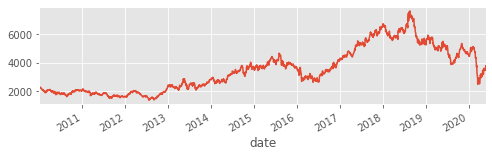

In [4]:
# スズキ
df = pd.read_csv(r'7269.csv',
                 index_col=0, parse_dates=[0], dtype='float', encoding='shift-jis')
display(df.head())

# pandasのSeriesに乗客数データを格納
ts = df['終値']
ts.index.name = 'date'
ts.name = 'close'
ts = ts['2010-01-01':]  # 2010年からにしてみる
display(ts)

# 乗客数データをグラフで可視化(pandas.plot)
ts.plot(figsize=(8, 2))

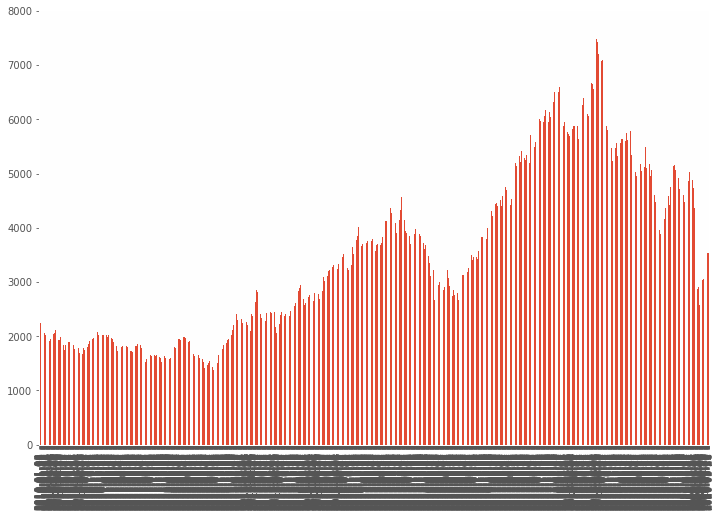

In [5]:
# 平均が多い日確認
month_mean = ts.groupby(ts.index.date).mean()
month_mean.plot.bar(figsize=(12, 8))

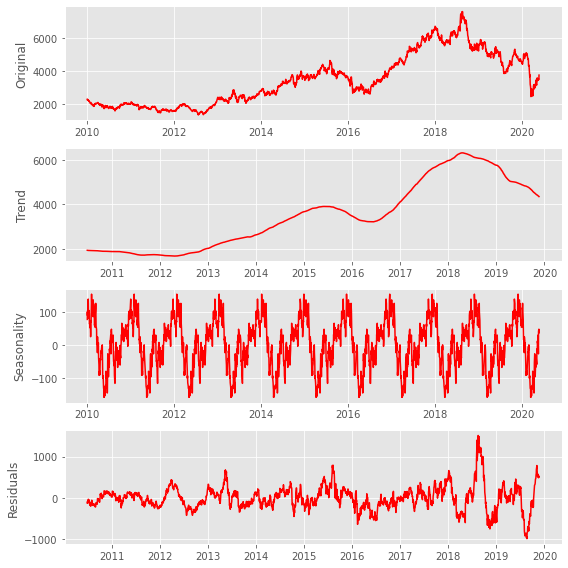

In [6]:
# オリジナル ->トレンド成分、季節成分、残差成分に分解してプロット
res = s_ana.plot_seasonal_decompose(ts, freq=20*12)

### 定常性確認+周期性確認

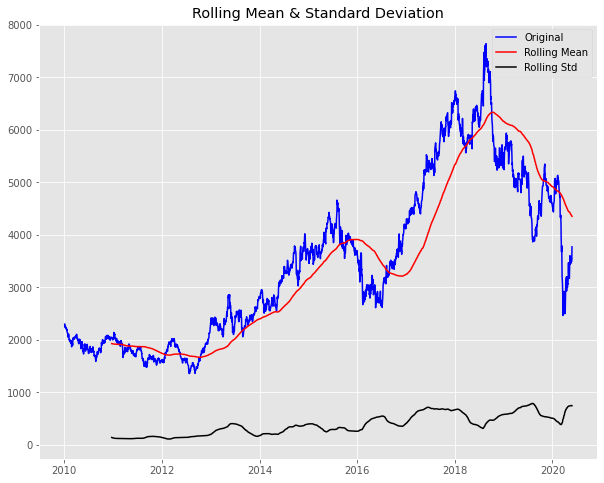

Results of Dickey-Fuller Test:
Test Statistic                   -1.493491
p-value                           0.536729
#Lags Used                       11.000000
Number of Observations Used    2527.000000
Critical Value (1%)              -3.432940
Critical Value (5%)              -2.862684
Critical Value (10%)             -2.567379
dtype: float64


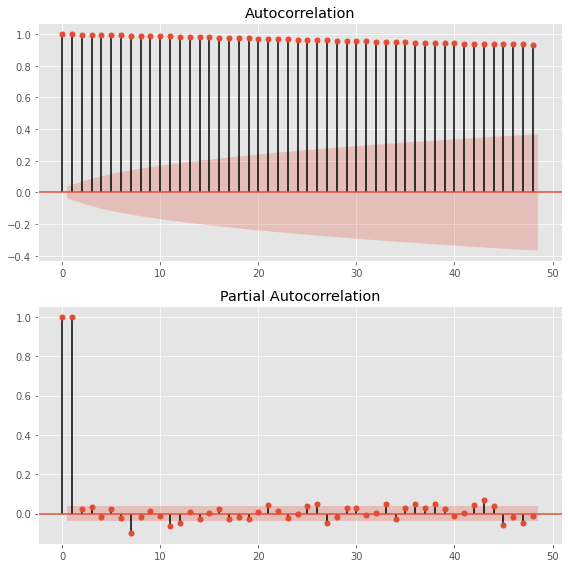

In [7]:
# p値高い(0.991880)ので帰無仮説棄却できない=データは非定常過と言える
s_ana.plot_stationarity(ts, window_size=20*12)

# 自己相関と偏自己相関のグラフplotして、過去の値が現在のデータにどれくらい影響しているか確認する
# タイムラグ（Lag）がゼロのときの自己相関は 1.00
# 時系列のグラフからもわかるように、ある年tの値が大きければ、その12か月後の値も大きい。
# そのために、連続する 12か月後の自己相関が高いことがわかる。
# しかし、タイムラグを長くすると、上昇から下落あるいは下落から上昇の区間のデータの影響が加わり、
# 自己相関が徐々に低くなる
s_ana.plot_acf_pacf(ts)

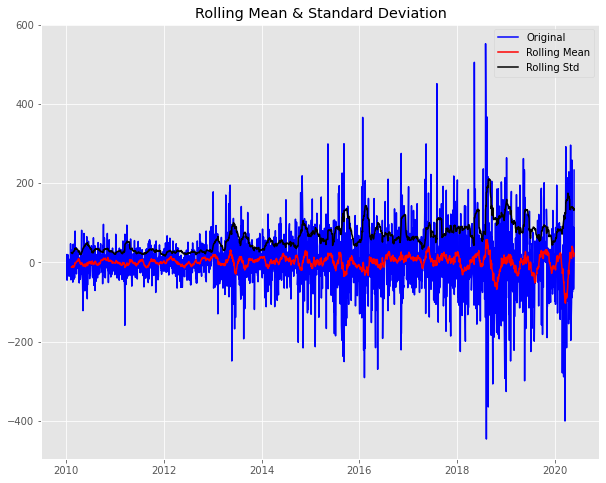

Results of Dickey-Fuller Test:
Test Statistic                -1.333063e+01
p-value                        6.193559e-25
#Lags Used                     1.000000e+01
Number of Observations Used    2.527000e+03
Critical Value (1%)           -3.432940e+00
Critical Value (5%)           -2.862684e+00
Critical Value (10%)          -2.567379e+00
dtype: float64


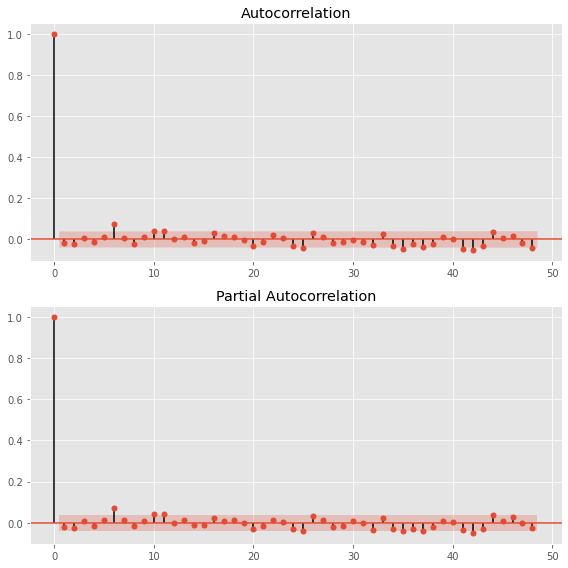

In [16]:
# 一次の差分を取り除いた場合
# p値<0.05(5%未満)なので、帰無仮説棄却＝データ定常
diff = ts - ts.shift(1)
diff = diff.dropna()
s_ana.plot_stationarity(diff, window_size=25)

# 自己相関と偏自己相関のグラフplotして、過去の値が現在のデータにどれくらい影響しているか確認する
# 一次の差分と、季節性を取り除いた場合が一番p値低いし、自己相関のplotから周期性取り除かれていることがわかる
s_ana.plot_acf_pacf(diff)

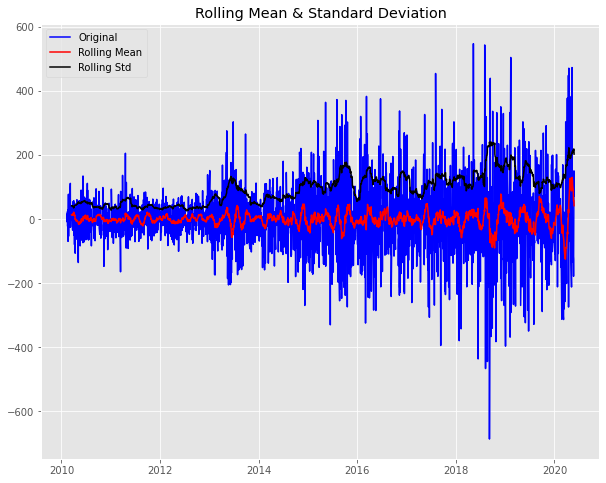

Results of Dickey-Fuller Test:
Test Statistic                -1.693955e+01
p-value                        9.640663e-30
#Lags Used                     2.400000e+01
Number of Observations Used    2.488000e+03
Critical Value (1%)           -3.432981e+00
Critical Value (5%)           -2.862702e+00
Critical Value (10%)          -2.567389e+00
dtype: float64


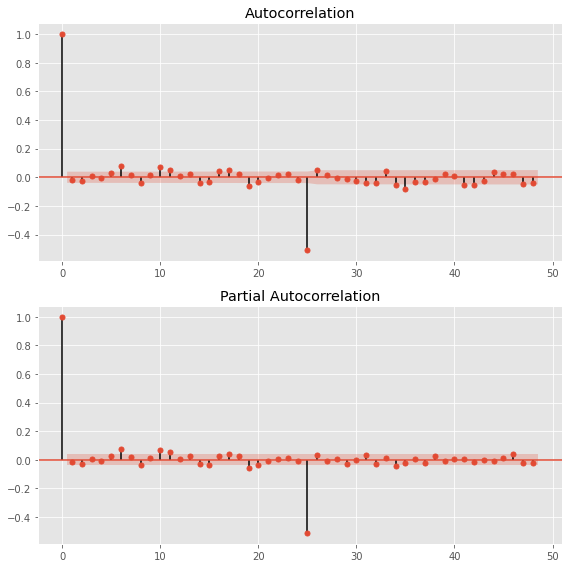

In [8]:
# 一次の差分と、季節性を取り除いた場合
# p値<0.05(5%未満)なので、帰無仮説棄却＝データ定常
diff = ts - ts.shift(1)
diff = diff.dropna()
diff = diff - diff.shift(25)
diff = diff.dropna()
s_ana.plot_stationarity(diff, window_size=25)

# 自己相関と偏自己相関のグラフplotして、過去の値が現在のデータにどれくらい影響しているか確認する
# 一次の差分と、季節性を取り除いた場合が一番p値低いし、自己相関のplotから周期性取り除かれていることがわかる
s_ana.plot_acf_pacf(diff)

### モデル作成+予測

In [22]:
args = {'input_csv': '7269.csv', 
        'output_dir': 'output',
        'n_trials': 30,
        'fix_param_s': 25
       }
        
# train/test set にデータ分割
# 周期性に合わせて分けないとうまくいかないことがあった
ts_train = ts['2010-01-01':'2019-12-31']
ts_test = ts['2020-01-01':]
print(ts_train.shape, ts_test.shape)

(2446,) (93,)


In [23]:
# 差分系列への自動ARMA推定関数の実行
# https://logics-of-blue.com/python-time-series-analysis/
resDiff = sm.tsa.arma_order_select_ic(ts_train, ic='aic', trend='nc')
resDiff

{'aic':               0             1             2
 0           NaN  43929.003648  40971.907362
 1  27787.647447  27784.730595  27784.633994
 2  27785.014682  27791.407320  27788.724030
 3  27784.896160  27786.240434  27794.263635
 4  27786.703159  27788.844980  27785.897661,
 'aic_min_order': (1, 2)}

In [24]:
# 試しにARIMAモデル作成
model = sm.tsa.ARIMA(ts_train, order=(1, 1, 2)).fit()
print('model.summary(): ', model.summary())

model.summary():                               ARIMA Model Results                              
Dep. Variable:                D.close   No. Observations:                 2445
Model:                 ARIMA(1, 1, 2)   Log Likelihood              -13878.342
Method:                       css-mle   S.D. of innovations             70.617
Date:                Thu, 28 May 2020   AIC                          27766.685
Time:                        22:00:50   BIC                          27795.694
Sample:                             1   HQIC                         27777.228
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.9304      1.299      0.716      0.474      -1.616       3.477
ar.L1.D.close     0.3351      0.356      0.942      0.346      -0.362       1.032
ma.L1.D.close    -0.38

In [25]:
# 試しにSARIMAXモデル作成
model = sm.tsa.statespace.SARIMAX(ts_train,
                                  trend=None,
                                  order=(1, 1, 2),
                                  seasonal_order=(1, 1, 1, 20),
                                  enforce_stationarity=False,
                                  enforce_invertibility=False
                                  ).fit()
print('model.summary(): ', model.summary())

model.summary():                                        SARIMAX Results                                       
Dep. Variable:                                close   No. Observations:                 2446
Model:             SARIMAX(1, 1, 2)x(1, 1, [1], 20)   Log Likelihood              -13688.878
Date:                              Thu, 28 May 2020   AIC                          27389.757
Time:                                      22:01:10   BIC                          27424.461
Sample:                                           0   HQIC                         27402.381
                                             - 2446                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3328      0.391      0.851      0.395      -0.434       1.100
m

In [11]:
# SARIMAXパラメータチューニング
study = s_ana.run_optuna(ts_train, 
                         args['output_dir'], 
                         n_trials=args['n_trials'], 
                         fix_s=args['fix_param_s'])

[I 2020-05-28 20:38:07,472] Finished trial#0 resulted in value: 27292.98850133644. Current best value is 27292.98850133644 with parameters: {'s': 25, 'trend': 'c', 'p': 4, 'd': 2, 'q': 2, 'P': 0, 'D': 1, 'Q': 1, 'enforce_stationarity': False, 'enforce_invertibility': False}.
[I 2020-05-28 20:40:42,431] Finished trial#1 resulted in value: 28448.871170650884. Current best value is 27292.98850133644 with parameters: {'s': 25, 'trend': 'c', 'p': 4, 'd': 2, 'q': 2, 'P': 0, 'D': 1, 'Q': 1, 'enforce_stationarity': False, 'enforce_invertibility': False}.
[I 2020-05-28 20:42:12,430] Finished trial#2 resulted in value: 27264.351722025967. Current best value is 27264.351722025967 with parameters: {'s': 25, 'trend': None, 'p': 4, 'd': 1, 'q': 4, 'P': 1, 'D': 1, 'Q': 1, 'enforce_stationarity': False, 'enforce_invertibility': False}.
[I 2020-05-28 20:42:14,986] Finished trial#3 resulted in value: 30976.26634569645. Current best value is 27264.351722025967 with parameters: {'s': 25, 'trend': None, 'p

試行回数: 30
目的関数を最小化するbestパラメータ: {'s': 25, 'trend': 'c', 'p': 2, 'd': 2, 'q': 4, 'P': 2, 'D': 0, 'Q': 2, 'enforce_stationarity': False, 'enforce_invertibility': False}
目的関数の最小値: 27191.05541438586


In [12]:
# bestパラメでモデル作成
model = sm.tsa.statespace.SARIMAX(ts_train,
                                  trend=study.best_params['trend'],
                                  order=(study.best_params['p'], 
                                         study.best_params['d'], 
                                         study.best_params['q']),
                                  seasonal_order=(study.best_params['P'], 
                                                  study.best_params['D'], 
                                                  study.best_params['Q'], 
                                                  study.best_params['s']),
                                  enforce_stationarity=study.best_params['enforce_stationarity'],
                                  enforce_invertibility=study.best_params['enforce_invertibility']
                                  ).fit()
print('model.summary(): ', model.summary())

# モデル保存
training_info = {'training_data': args['input_csv'], 'model_type': 'SARIMAX', 'hyper_pram': study.best_params}
save_data, filepath = s_ana.save_model_info(model,
                                      training_info,
                                      preprocess_pipeline=None,
                                      output_path=os.path.join(args['output_dir'], '7269_SARIMAX_best.joblib'))

model.summary():                                   Statespace Model Results                                 
Dep. Variable:                              close   No. Observations:                 2446
Model:             SARIMAX(2, 2, 4)x(2, 0, 2, 25)   Log Likelihood              -13583.528
Date:                            Thu, 28 May 2020   AIC                          27191.055
Time:                                    21:28:24   BIC                          27260.399
Sample:                                         0   HQIC                         27216.289
                                           - 2446                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   6.606e-05      0.007      0.010      0.992      -0.013       0.013
ar.L1         -0.

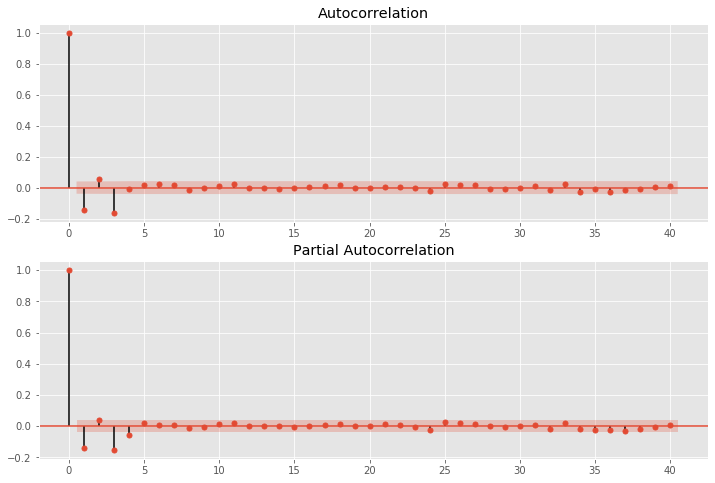

In [14]:
# 残差のチェック
residSARIMA = model.resid
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(residSARIMA, lags=40, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(residSARIMA, lags=40, ax=ax2)

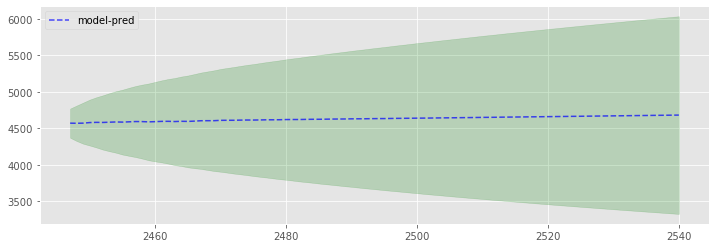

In [13]:
load_data = joblib.load(filepath)
# 予測
# index（日付）が飛び飛びなので %Y-%m-%d 形式でstart, end 指定するとエラーになる。行番号で指定したらいけた
ts_pred = s_ana.predict_load_model(filepath,
                                   len(ts_train)+1, #ts_test.index[0].strftime('%Y-%m-%d'),
                                   len(ts_train)+1 + len(ts_test), #ts_test.index[-1].strftime('%Y-%m-%d'),
                                   #ts=ts_train,
                                   out_png=os.path.join(args['output_dir'], '7269_ts_pred.png'))

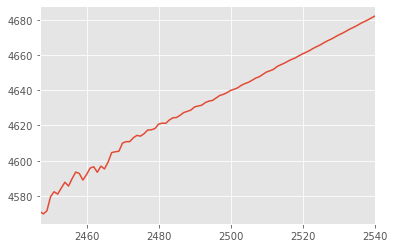

In [15]:
ts_pred.plot()

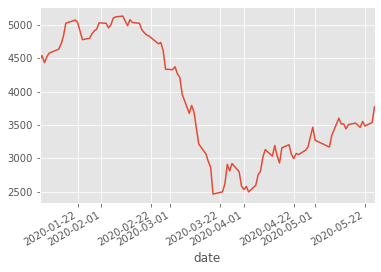

In [16]:
ts_test.plot()